# Setup

In [791]:
#!/usr/bin/env python3
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

plt.style.use(["science", "nature", "notebook"])
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Computer", "Noto Serif CJK jp"],
        "font.size": 11,
        "text.usetex": False,
        "mathtext.fontset": "stixsans",
        "figure.figsize": (5, 3),
    }
)

from prep import *
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import functools

df = pd.read_csv("../data/viz_learn_preds.csv", index_col=0)


def linear_model(formula, df, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    preds = results.predict(df)
    targs = df[targ]
    if model_name is None:
        model_name = formula.format(targ)
    fig, annot = plot_regression_once(preds, targs, model_name)
    return results, fig


@functools.lru_cache
def lm(formula, targ, model_name=None):
    results = smf.ols(formula.format(targ), data=df).fit()
    return results


def set_base(ser, base):
    cats = list(ser.unique())
    idx = cats.index(base)
    cats[idx] = cats[0]
    cats[0] = base
    return pd.Categorical(ser, categories=cats)

In [792]:
df["station"] = set_base(df["station"], "ＪＲ山手線/浜松町駅")
df["method"] = set_base(df["method"], "歩")
df["apt_style"] = df["apt_style"].apply(apt_style_clean)
df["time_to_station_sq"] = df["time_to_station"] ** 2
df["apt_style"] = set_base(df["apt_style"], "ワンルーム")
# df = df[df["valid"]]

In [793]:
mod1 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style",
    # "+ viz_preds",
    "log_apt_rent",
    model_name="Simple",
)

mod2 = lm(
    "{} ~ b_age"
    "+ apt_size"
    "+ b_no_floors"
    "+ apt_floor"
    "+ apt_admin_price"
    "+ time_to_station"
    "+ time_to_station_sq"
    "+ C(method)"
    "+ C(station)"
    "+ apt_style"
    "+ viz_preds",
    "log_apt_rent",
    model_name="Simple",
)

# Stargazer

In [794]:
from stargazer.stargazer import Stargazer

def latex_format(name, cap):
    template = "\n\caption{{\label{{{}}}{}}}\n"
    return template.format(name, cap)
    
def write_label(capstring, tab_file):
    outstring=""
    with open(tab_file, "r") as f:
        outstring = (f" {capstring} ".join(f.readline().split(" ")))
        outstring += f.read()
    with open(tab_file, "w") as f:
        f.write(outstring)
        
sg = Stargazer([mod1, mod2])
styles = list(filter(lambda x: x.startswith("apt_style"), sg.cov_names))

order = [
    "Intercept",
    "apt_size",
    "b_age",
    "b_no_floors",
    "apt_floor",
    "apt_admin_price",
    "time_to_station",
    "time_to_station_sq",
    "viz_preds"
] #+ styles

sg.covariate_order(order)

sg.rename_covariates({
    "apt_size": "Apartment Size(\(m^2\))",
    "b_no_floors": "No. Floors(Building)",
    "b_age": "Building age",
    "apt_floor": "Apartment Floor",
    "apt_admin_price": "Administration Price",
    "time_to_station" : "Time to station",
    "time_to_station_sq": "Time to station\(^2\)",
    "viz_preds": 'NN "attractiveness"',
})
sg.custom_columns(['Without NN', 'With NN'], [1, 1])
sg.show_model_numbers(False)
sg.add_custom_notes(['"df" denotes the degrees of freedom'])
sg.dependent_variable_name("Dependent variable: \( log(apt\_rent) \)")
sg.dependent_variable = ""

In [795]:
sg

In [796]:
# tab_file="../../paper/assets/table2.tex" 
# with open(tab_file, "w") as f:
#     f.write(sg.render_latex())

In [797]:
# # \caption{\label{tab:var_explanation}An explanation of the variables that were collected and used in this study.}
# cap = """Esimated coefficients (Standard Erorrs) for the variables in Table \\ref{tab:var_explanations}.
# These coefficients were estimated with the hedonic price model explained. However, because of the high cardinality 
# of the categorical variables of Apartment style and closest station, we excluded the two variables here.
# """
# name = "tab:regression"
# capstring = latex_format(name, cap)

# write_label(capstring, tab_file)

# Looking at predictions

In [798]:
import os 
from PIL import Image
from pathlib import Path
from IPython.display import Image
from IPython.display import display
import matplotlib.image as mplimg


In [799]:
root =  Path("/Users/jiyanschneider/Dropbox/scraper/imgs/")
def image_path(f, path=root):
    return mplimg.imread(path / f)


In [800]:
df["exp_viz_preds"] = np.exp(df["viz_preds"])
df["exp_viz_targs"] = np.exp(df["viz_targs"])
   

In [ ]:
def show_imgs(l, title=None, **kwargs):
    no_imgs = len(l)
    n_rows = no_imgs//4
    n_cols = 4
    fig, axs = plt.subplots(n_rows,n_cols, **kwargs)
    for (ax, (img, pred, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{pred:.2f}/{actual:.2f}")
    if not title:
        plt.suptitle("Prediction/Actual", fontsize=20)
    else:
        plt.suptitle(title, fontsize=20)
    return fig

def show_pred_imgs(l, **kwargs):
    no_imgs = len(l)
    n_rows = no_imgs//4
    n_cols = 4
    fig, axs = plt.subplots(n_rows,n_cols, **kwargs)
    for (ax, (img, mod1, mod2, NN, actual) ) in zip(axs.flatten(),l):
        ax.imshow(image_path(img))
        ax.axis("off")
        ax.set_title(f"{mod1:.2f}/{mod2:.2f}/{NN:.2f}/{actual:.2f}")
    plt.suptitle("Model1/Model2/NN/Actual", fontsize=20)
    return fig


def image_triple(idxs, exp=True):
    if exp:
        return list(df[["rel_image_paths", "exp_viz_preds", "exp_viz_targs"]].loc[idxs].to_records(index=False))
    else: 
        return list(df[["rel_image_paths", "viz_preds", "viz_targs"]].loc[idxs].to_records(index=False))

def pred_tup(idxs, cols):
    return list(df[["rel_image_paths", *cols]].loc[idxs].to_records(index=False))
        

def random_images(N, seed=None):
    if seed is not None:
        np.random.seed(seed)
    rands = list(np.random.randint(0, len(df), size=N))
    return image_triple(rands)



## Random predictions

In [802]:
random_images(5)

[('full/a1032c3691e3f9d1e714e75805acf0d977a6cfb6.jpg', 7.04621787, 9.29999907),
 ('full/e95b6515e9d21f774cd80def2772c32ac89e9037.jpg', 5.83656944, 5.19999987),
 ('full/8bf5317b9dd7f24461964357a9248f343f3b6d9a.jpg', 9.0914899, 12.99999925),
 ('full/08debb7cc30f0922412e284fdd70bbca66c6b358.jpg', 9.90842098, 9.95000049),
 ('full/0d710381934514a9ba552060093a40946d1bf58d.jpg', 8.63531681, 6.60000034)]

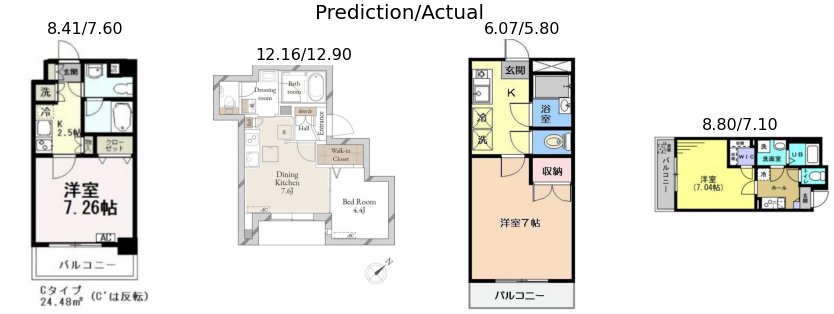

In [803]:
x = show_imgs(random_images(4, seed=2021), figsize=(15, 5))
# x.savefig("../../paper/assets/random_table.png", dpi=300)

In [804]:
from fastcore.all import L

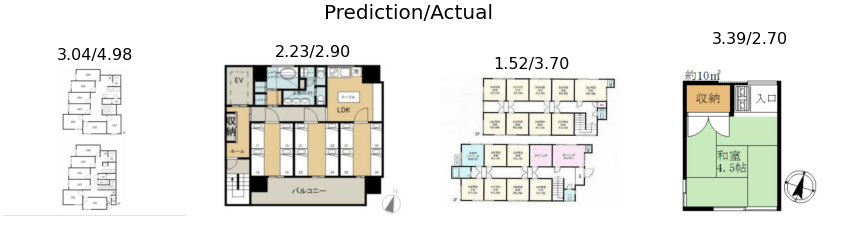

In [805]:
M = 100
N = 12
highest_idx = L(df.sort_values("viz_preds").index.to_list()[:M])
np.random.seed(41)
rands = highest_idx[list(np.random.randint(0, M, 4))]
x = show_imgs(image_triple(rands), figsize=(15, 4))
# x.savefig("../../paper/assets/random_negtop100.png")

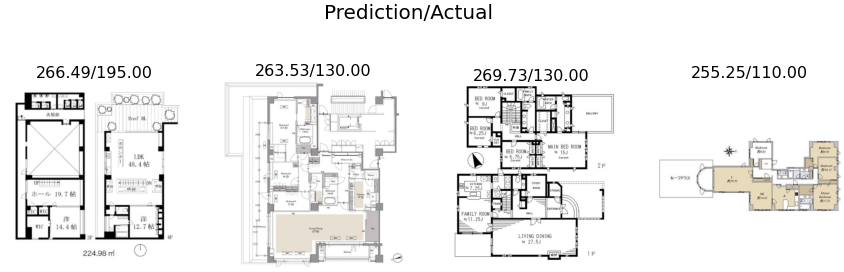

In [818]:
highest_idx = L(df.sort_values("viz_preds", ascending=False).index.to_list()[:M])
np.random.seed(49)
rands = highest_idx[list(np.random.randint(0, M, 4))]
x = show_imgs(image_triple(rands), figsize=(15, 5))
x.savefig("../../paper/assets/rand_top_100.png", dpi=600)

In [821]:
np.exp(6)

403.4287934927351

In [807]:
df["mod1preds"] = mod1.predict(df)
df["mod2preds"] = mod2.predict(df)
df["exp_mod1preds"] = np.exp(df["mod1preds"])
df["exp_mod2preds"] = np.exp(df["mod2preds"])

In [808]:
mistakes = (df["mod1preds"] - df["mod2preds"]).sort_values()

In [809]:
underestimates = mistakes[:4].index.to_list()
overestimates = mistakes[-10:-5].index.to_list()

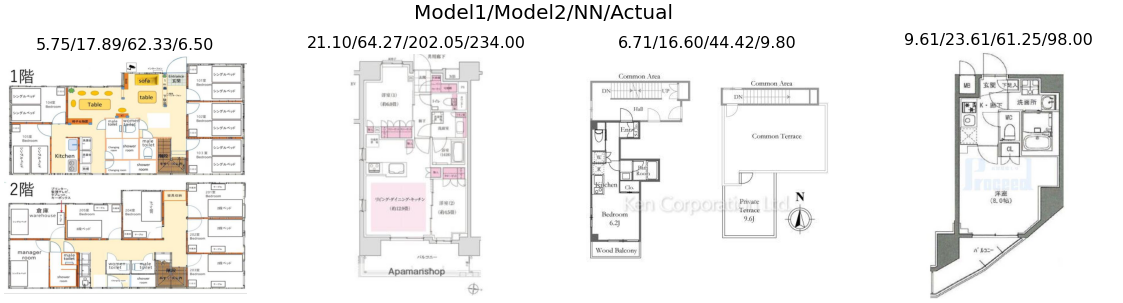

In [810]:
x = show_pred_imgs(pred_tup(underestimates, ("exp_mod1preds", "exp_mod2preds","exp_viz_preds", "exp_viz_targs")),figsize=(20, 5))
# x.savefig("../../paper/assets/underpreds.png", dpi=300)

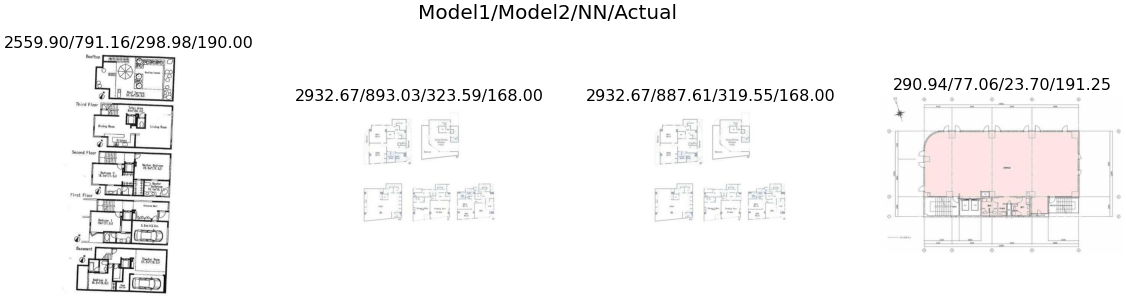

In [811]:
x = show_pred_imgs(pred_tup(overestimates, ("exp_mod1preds", "exp_mod2preds","exp_viz_preds", "exp_viz_targs")),figsize=(20, 5))
# x.savefig("../../paper/assets/overpreds.png", dpi=300)

In [812]:
df["exp_viz_targs"].max()

250.00002053443933

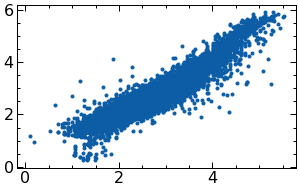

In [813]:
plt.scatter(df["viz_targs"], df["viz_preds"])

In [814]:
df["valid"]

0          True
1         False
2         False
3         False
4         False
          ...  
141389    False
141390    False
141391     True
141392     True
141393    False
Name: valid, Length: 141394, dtype: bool

In [815]:
((df[df["valid"]]["viz_preds"] - df[df["valid"]]["viz_targs"])**2).mean()

0.03420798895859065